# Notebook setup
I will focus on using AdaBoost, using several initial base estimators such as KNN, SVC and Logistic.

In [1]:
#Basic packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
from colorsetup import colors, palette

## Metrics definition

Since I want to focus on effectively predicting the negative values, I define new metrics that focus on the quality of the model to predict the negative values.

In [2]:
#Classification metrics
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, make_scorer, recall_score, precision_score
from sklearn.metrics import roc_curve, precision_recall_curve

In [3]:
#Defining negative prediction based classification metrics
specificity = make_scorer(precision_score, pos_label = 0)
npv = make_scorer(recall_score, pos_label = 0)

In [4]:
#Importing the models:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier, RandomForestClassifier, GradientBoostingClassifier

In [5]:
#Helper function to plot the models:
sns.set_context('talk')
def plot_models(predictions, labels):
    metrics = []
    cm = []
    for model, label in zip(predictions, labels):
        precision, recall, fscore, _ = score(y_test, model, average='binary')
        accuracy = accuracy_score(y_test, model)
        tnr = precision_score(y_test, model, pos_label = 0, average = 'binary')
        cm.append(confusion_matrix(y_test, model, labels = [1, 0]))
        metrics.append(pd.Series({'precision':precision, 
                                  'recall':recall, 
                                  'fscore':fscore,
                                  'specificity':tnr, 
                                  'NPV' : recall_score(y_test, model, pos_label = 0, average = 'binary'),
                                  'accuracy':accuracy, }, name=label))
    metrics = pd.concat(metrics, axis=1)
    rows = int(np.ceil((len(labels) - 4) / 4) + 1)
    fig, axList = plt.subplots(nrows=rows, ncols=4)
    axList = axList.flatten()
    fig.set_size_inches(18, 3.5 * rows)
    for ax in enumerate(axList):
        loc = ax[0]
        ax = ax[1]
        if loc < len(cm):
            sns.heatmap(cm[loc], annot=True, fmt='d', cmap=colors, ax = ax, xticklabels = [1, 0], yticklabels = [1, 0], square = True)
            ax.set(title= labels[loc])
        else:
            ax.axis("off")
    plt.tight_layout()
    return metrics.T

In [6]:
#Helper function to plot the trained models:
sns.set_context('talk')
def plot_models_train(predictions, labels):
    metrics = []
    cm = []
    for model, label in zip(predictions, labels):
        precision, recall, fscore, _ = score(y_train, model, average='binary')
        accuracy = accuracy_score(y_train, model)
        tnr = precision_score(y_train, model, pos_label = 0, average = 'binary')
        cm.append(confusion_matrix(y_train, model, labels = [1, 0]))
        metrics.append(pd.Series({'precision':precision, 
                                  'recall':recall, 
                                  'fscore':fscore,
                                  'specificity':tnr, 
                                  'NPV' : recall_score(y_train, model, pos_label = 0, average = 'binary'),
                                  'accuracy':accuracy, }, name=label))
    metrics = pd.concat(metrics, axis=1)
    rows = int(np.ceil((len(labels) - 4) / 4) + 1)
    fig, axList = plt.subplots(nrows=rows, ncols=4)
    axList = axList.flatten()
    fig.set_size_inches(18, 3.5 * rows)
    for ax in enumerate(axList):
        loc = ax[0]
        ax = ax[1]
        if loc < len(cm):
            sns.heatmap(cm[loc], annot=True, fmt='d', cmap=colors, ax = ax, xticklabels = [1, 0], yticklabels = [1, 0], square = True)
            ax.set(title= labels[loc])
        else:
            ax.axis("off")
    plt.tight_layout()
    return metrics.T

# Data

The data has been scaled and outliers dealt with in previous notebooks.

In [7]:
df = pd.read_csv('credit.csv')
df.drop(columns = 'telephone', inplace = True)

<AxesSubplot:>

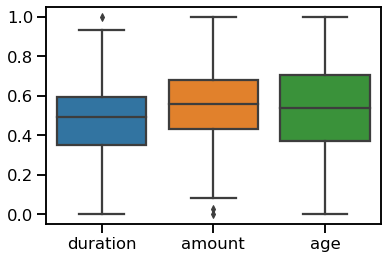

In [8]:
sns.boxplot(data = df[['duration', 'amount', 'age']])

In [9]:
credit_risk, features = df['credit_risk'], df.drop(columns='credit_risk')
feature_cols = features.columns

## Stratified split of the Data

In [10]:
# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(features, credit_risk))

# Create the dataframes
X_train = df.loc[train_idx, feature_cols]
y_train = df.loc[train_idx, 'credit_risk']

X_test  = df.loc[test_idx, feature_cols]
y_test  = df.loc[test_idx, 'credit_risk']

# Base estimators

## Base Support Vector Classifier (SVC)

In [11]:
svc_model = SVC(C = 1, kernel = 'rbf', gamma = 'scale', class_weight = None, random_state = 42)
svc_predict = svc_model.fit(X_train, y_train).predict(X_test)
svc_train = svc_model.predict(X_train)

### Grid Search on SVC, with Negative Predictive Value scoring (NPV)

In [12]:
svc_grid = {'C': [0.001, 0.01, 0.1, 1,10,20],  
            'gamma' : [[0.001, 0.01, 0.1, 1, 10, 20], 'scale', 'auto'], 
            'class_weight' : ['balanced', None]}
svc_GS = SVC(probability = True, random_state = 42)
svc_GS_model = GridSearchCV(svc_GS, 
                            param_grid = svc_grid, 
                            scoring = npv, 
                            n_jobs = -1)
svc_GS_predict = svc_GS_model.fit(X_train, y_train).predict(X_test)
svc_GS_model.best_params_

{'C': 0.001, 'class_weight': 'balanced', 'gamma': 'scale'}

In [13]:
svc_GS_model.best_estimator_

SVC(C=0.001, class_weight='balanced', probability=True, random_state=42)

### Grid Search on SVC, with Specificity scoring (SPC)

In [14]:
svc_grid = {'C': [0.001, 0.01, 0.1, 1,10,20],  
            'gamma' : [[0.001, 0.01, 0.1, 1, 10, 20], 'scale', 'auto'], 
            'class_weight' : ['balanced', None]}
svc_GS = SVC(random_state = 42)
svc_GS_model_spc = GridSearchCV(svc_GS, 
                            param_grid = svc_grid, 
                            scoring = specificity, 
                            n_jobs = -1)
svc_GS_predict_spc = svc_GS_model_spc.fit(X_train, y_train).predict(X_test)
svc_GS_model_spc.best_params_

{'C': 10, 'class_weight': None, 'gamma': 'auto'}

## Base Logistic Regression (LR)

In [15]:
lr_model = LogisticRegression(penalty = 'l2', solver = 'liblinear', C = 0.1)
lr_predict = lr_model.fit(X_train, y_train).predict(X_test)
lr_predict_t = lr_model.predict(X_train)

## Base K-Nearest Neighbors (KNN)

In [16]:
knn_model = KNeighborsClassifier(n_neighbors=30)
knn_predict = knn_model.fit(X_train, y_train).predict(X_test)
knn_predict_t = knn_model.predict(X_train)

### Grid Search on K-Nearest Neighbors with Negative Predictive Value scoring (NPV)

In [17]:
knn_grid = {'n_neighbors' : list(range(3, 11)),
            'weights' : ['distance', 'uniform']}
knn_GS_model = GridSearchCV(KNeighborsClassifier(), 
                               param_grid = knn_grid, 
                               scoring = npv,
                               n_jobs = -1)
knn_GS_predict = knn_GS_model.fit(X_train, y_train).predict(X_test)
knn_GS_train_p = knn_GS_model.predict(X_train)
knn_GS_model.best_params_

{'n_neighbors': 4, 'weights': 'uniform'}

In [49]:
knn_GS_model.best_estimator_

KNeighborsClassifier(n_neighbors=4)

### Gird Search on K-Nearest Neighbors with multiple scoring, refit NPV

In [38]:
scoring_dict = {'prec': 'precision',
                'rec' : 'recall',
                'spc' : specificity,
                'npv' : npv,
                'f1' : 'f1',
                'acc' : 'accuracy'}
knn_GS_model_scoring = GridSearchCV(KNeighborsClassifier(), 
                               param_grid = knn_grid, 
                               scoring = scoring_dict,
                               refit = 'npv',
                               n_jobs = -1)
knn_GS_predict_scoring = knn_GS_model_scoring.fit(X_train, y_train).predict(X_test)
knn_GS_model_scoring.best_params_

{'n_neighbors': 4, 'weights': 'uniform'}

## Confusion Matrix on train data

,precision,recall,fscore,specificity,NPV,accuracy
Train SVC,0.824232,0.985714,0.897770,0.938596,0.509524,0.842857
Train Logistic,0.756579,0.938776,0.837887,0.673913,0.295238,0.745714
Train KNN,0.738170,0.955102,0.832740,0.666667,0.209524,0.731429
Train GS KNN NPV,0.878319,0.810204,0.842887,0.625000,0.738095,0.788571


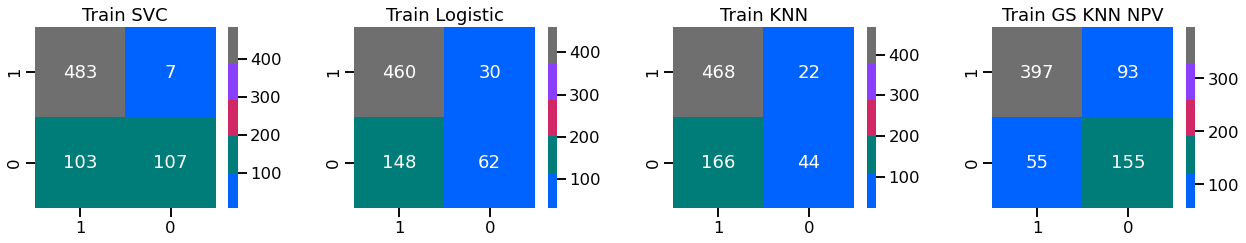

In [19]:
base_train = [svc_train, 
               lr_predict_t, 
               knn_predict_t, 
               knn_GS_train_p]
base_labels = ['Train SVC',
          'Train Logistic', 
          'Train KNN', 
          'Train GS KNN NPV']
plot_models_train(base_train, base_labels)

## Confusion Matrix on test data

H:\Users\Valhala\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,fscore,specificity,NPV,accuracy
Base SVC,0.767442,0.942857,0.846154,0.714286,0.333333,0.760000
GS SVC NPV,0.000000,0.000000,0.000000,0.300000,1.000000,0.300000
Base Logistic,0.776471,0.942857,0.851613,0.733333,0.366667,0.770000
Base KNN,0.733813,0.971429,0.836066,0.727273,0.177778,0.733333
GS KNN NPV,0.790244,0.771429,0.780723,0.494737,0.522222,0.696667


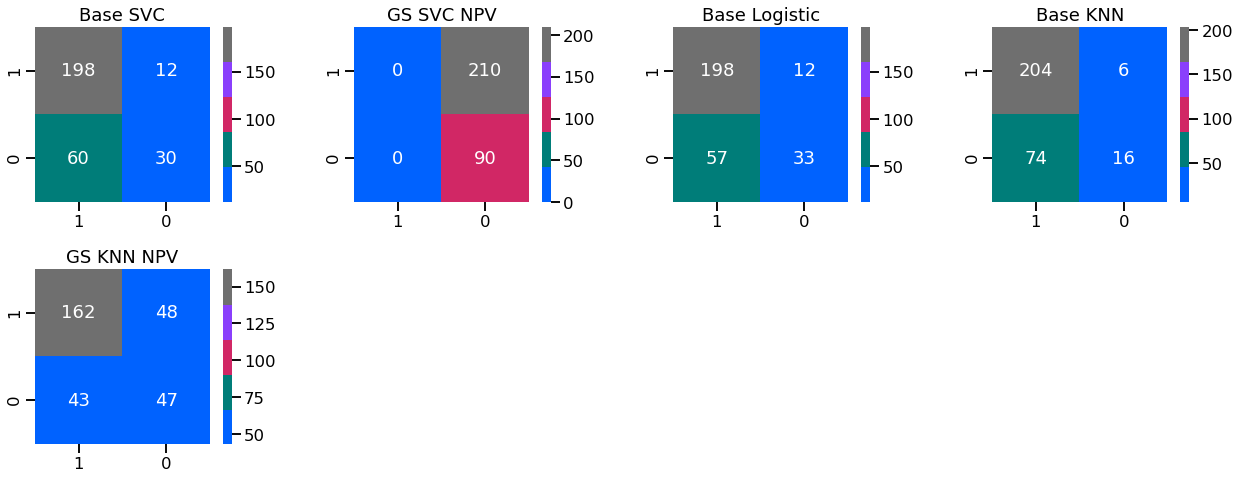

In [18]:
base_models = [svc_model,
               svc_GS_model,
          lr_model,
          knn_model,
          knn_GS_model]
base_predictions = [svc_predict, 
                    svc_GS_predict,
                   lr_predict, 
                   knn_predict, 
                   knn_GS_predict]
base_labels = ['Base SVC',
               'GS SVC NPV',
          'Base Logistic', 
          'Base KNN', 
          'GS KNN NPV']
plot_models(base_predictions, base_labels)

# Ensamble Models

## AdaBoost

### AdaBoost Support Vector Classifier (SVC)

In [39]:
ada_model_SVC = AdaBoostClassifier(base_estimator = svc_model, 
                               n_estimators = 100,
                               algorithm = 'SAMME',
                               random_state = 42)
ada_SVC_predict = ada_model_SVC.fit(X_train, y_train).predict(X_test)

### AdaBoost Logistic Regression (LR)

In [40]:
ada_model_LR = AdaBoostClassifier(base_estimator = lr_model, 
                               n_estimators = 100,
                               algorithm = 'SAMME.R',
                               random_state = 42).fit(X_train, y_train)
ada_LR_predict = ada_model_LR.predict(X_test)

### AdaBoost Decision Tree (DT)

In [41]:
ada_model_DT = AdaBoostClassifier(n_estimators = 100, random_state = 42)
ada_DT_predict = ada_model_DT.fit(X_train, y_train).predict(X_test)

### Base models VS Adaboost models CM

H:\Users\Valhala\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,fscore,specificity,NPV,accuracy
Base SVC,0.767442,0.942857,0.846154,0.714286,0.333333,0.760000
Base Logistic,0.776471,0.942857,0.851613,0.733333,0.366667,0.770000
Base KNN,0.733813,0.971429,0.836066,0.727273,0.177778,0.733333
GS KNN NPV,0.790244,0.771429,0.780723,0.494737,0.522222,0.696667
AdaBoost SVC,0.700000,1.000000,0.823529,0.000000,0.000000,0.700000
AdaBoost Logistic,0.703704,0.995238,0.824458,0.666667,0.022222,0.703333
AdaBoost Decision Tree,0.799107,0.852381,0.824885,0.592105,0.500000,0.746667


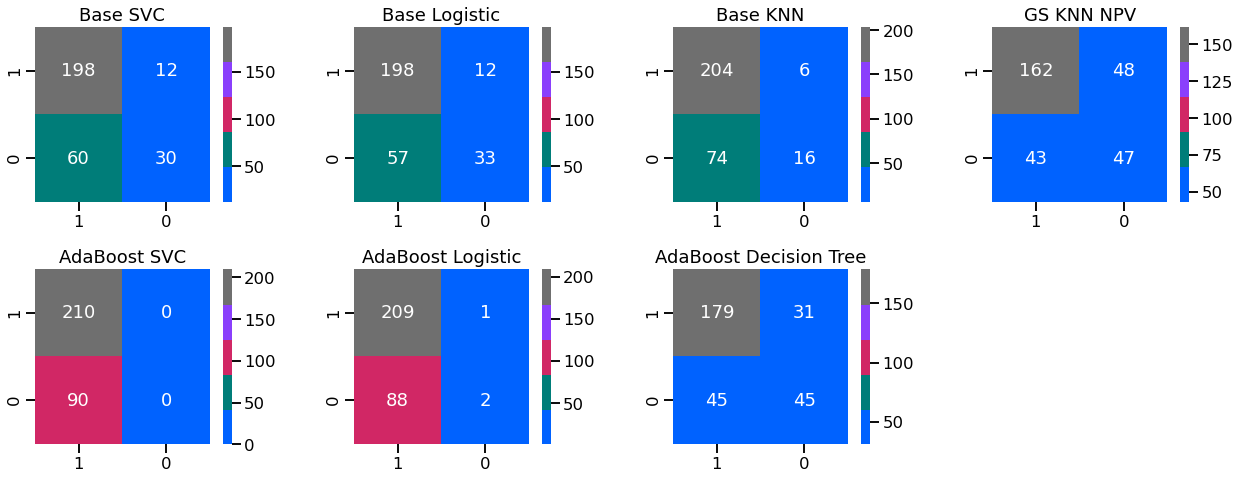

In [24]:
predictions = [svc_predict, 
               lr_predict, 
               knn_predict, 
               knn_GS_predict,
               ada_SVC_predict,
               ada_LR_predict,
               ada_DT_predict]
labels = ['Base SVC',
          'Base Logistic', 
          'Base KNN', 
          'GS KNN NPV',
          'AdaBoost SVC',
          'AdaBoost Logistic',
          'AdaBoost Decision Tree']
plot_models(predictions, labels)

### Gridsearch on Adaboost Models

#### Grid Search on AdaBoost SVC with specificity scoring (SPC) 

In [42]:
ada_grid_SVC = {'n_estimators' : [50, 75, 100, 150, 200],
            'learning_rate' : [0.5, 0.75, 1]}
ada_SVC_GS_model = GridSearchCV(AdaBoostClassifier(base_estimator = svc_model, algorithm = 'SAMME', random_state = 42), 
                               param_grid = ada_grid_SVC,
                               scoring = specificity,
                               n_jobs = -1).fit(X_train, y_train)
ada_SVC_GS_predict = ada_SVC_GS_model.predict(X_test)
ada_SVC_GS_model.best_params_

{'learning_rate': 0.5, 'n_estimators': 50}

#### Grid Search on AdaBoost LR with NPV

In [43]:
ada_grid_LR = {'n_estimators' : [50, 75, 100, 150, 200],
            'learning_rate' : [0.5, 0.75, 1]}
ada_LR_GS_model = GridSearchCV(AdaBoostClassifier(base_estimator = lr_model, algorithm = 'SAMME.R', random_state = 42), 
                               param_grid = ada_grid_LR, 
                               scoring = npv,
                               n_jobs = -1).fit(X_train, y_train)
ada_LR_GS_predict = ada_LR_GS_model.predict(X_test)
ada_LR_GS_model.best_params_

{'learning_rate': 1, 'n_estimators': 200}

In [44]:
ada_LR_GS_model.best_estimator_

AdaBoostClassifier(base_estimator=LogisticRegression(C=0.1, solver='liblinear'),
                   learning_rate=1, n_estimators=200, random_state=42)

#### Grid Search on AdaBoost DT with specificity scoring (SPC) 

In [45]:
ada_grid_DT = {'n_estimators' : [50, 75, 100, 150, 200],
            'learning_rate' : [0.5, 0.75, 1]}
ada_DT_GS_model = GridSearchCV(AdaBoostClassifier(random_state = 42), 
                               param_grid = ada_grid_DT, 
                               scoring = specificity,
                               n_jobs = -1).fit(X_train, y_train)
ada_DT_GS_predict = ada_DT_GS_model.predict(X_test)
ada_DT_GS_model.best_params_

{'learning_rate': 0.5, 'n_estimators': 50}

### Confusion Matrix of AdaBoost Models

H:\Users\Valhala\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,fscore,specificity,NPV,accuracy
Base SVC,0.767442,0.942857,0.846154,0.714286,0.333333,0.760000
Base Logistic,0.776471,0.942857,0.851613,0.733333,0.366667,0.770000
Base KNN,0.733813,0.971429,0.836066,0.727273,0.177778,0.733333
GS KNN NPV,0.790244,0.771429,0.780723,0.494737,0.522222,0.696667
AdaBoost SVC,0.700000,1.000000,0.823529,0.000000,0.000000,0.700000
AdaBoost Logistic,0.703704,0.995238,0.824458,0.666667,0.022222,0.703333
AdaBoost Decision Tree,0.799107,0.852381,0.824885,0.592105,0.500000,0.746667
GS AdaBoost SVC SPC,0.700000,1.000000,0.823529,0.000000,0.000000,0.700000
GS AdaBoost LR NPV,0.753676,0.976190,0.850622,0.821429,0.255556,0.760000
GS AdaBoost DT SPC,0.799145,0.890476,0.842342,0.651515,0.477778,0.766667


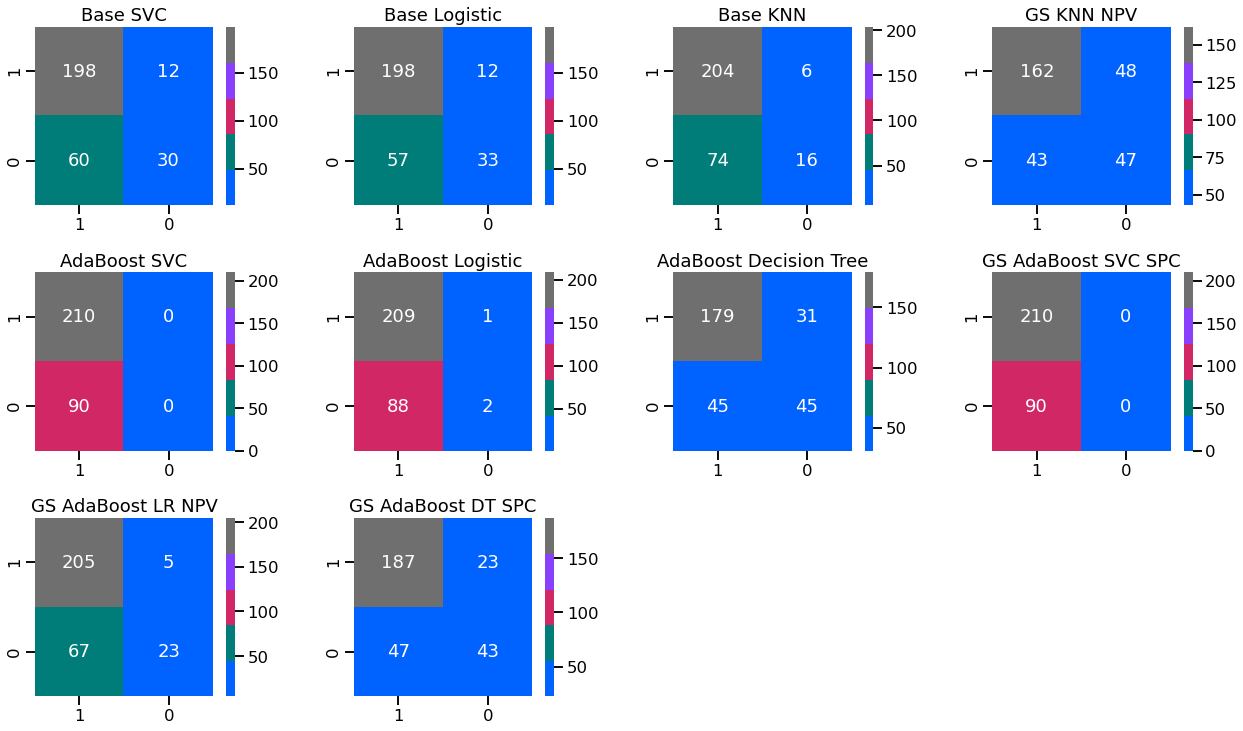

In [29]:
predictions_2 = [svc_predict, 
               lr_predict, 
               knn_predict, 
               knn_GS_predict,
               ada_SVC_predict,
               ada_LR_predict,
               ada_DT_predict,
               ada_SVC_GS_predict,
               ada_LR_GS_predict,
               ada_DT_GS_predict]
labels_2 = ['Base SVC',
          'Base Logistic', 
          'Base KNN', 
          'GS KNN NPV',
          'AdaBoost SVC',
          'AdaBoost Logistic',
          'AdaBoost Decision Tree',
          'GS AdaBoost SVC SPC',
          'GS AdaBoost LR NPV',
          'GS AdaBoost DT SPC'
           ]
plot_models(predictions_2, labels_2)

## Voting Classifier

### Voting with base estimators and Adaboost models

In [46]:
voting_estimators = [('knn', knn_GS_model.best_estimator_),
                     ('ada_dt', ada_model_DT),
                     ('gs_ada_lr', ada_LR_GS_model.best_estimator_), 
                     ('gs_ada_dt', ada_DT_GS_model.best_estimator_)]

,precision,recall,fscore,specificity,NPV,accuracy
GS KNN NPV,0.790244,0.771429,0.780723,0.494737,0.522222,0.696667
AdaBoost Decision Tree,0.799107,0.852381,0.824885,0.592105,0.500000,0.746667
GS AdaBoost LR NPV,0.753676,0.976190,0.850622,0.821429,0.255556,0.760000
GS AdaBoost DT SPC,0.799145,0.890476,0.842342,0.651515,0.477778,0.766667


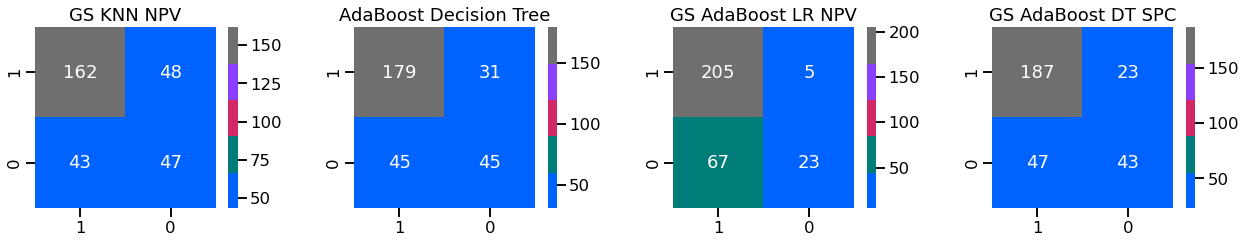

In [47]:
predictions_1 = [knn_GS_predict,
               ada_DT_predict,
               ada_LR_GS_predict,
               ada_DT_GS_predict]
labels_1 = ['GS KNN NPV',
          'AdaBoost Decision Tree',
          'GS AdaBoost LR NPV',
          'GS AdaBoost DT SPC']
plot_models(predictions_1, labels_1)

,precision,recall,fscore,specificity,NPV,accuracy
Voting Hard,0.821596,0.833333,0.827423,0.597701,0.577778,0.756667
Voting Soft,0.806867,0.895238,0.848758,0.671642,0.500000,0.776667


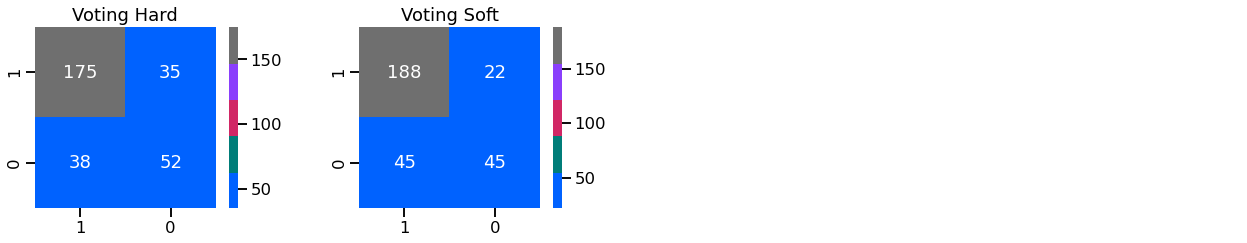

In [48]:
voting_weights = [0, 1, 0, 1]
voting_model_hard = VotingClassifier(estimators = voting_estimators, voting = 'hard', weights = voting_weights).fit(X_train, y_train)
voting_model_soft = VotingClassifier(estimators = voting_estimators, voting = 'soft', weights = voting_weights).fit(X_train, y_train)
voting_predict_hard = voting_model_hard.predict(X_test)
voting_predict_soft = voting_model_soft.predict(X_test)
#Predictions
predictions_4 = [voting_predict_hard,
               voting_predict_soft]
labels_4 = ['Voting Hard',
          'Voting Soft']
plot_models(predictions_4, labels_4)

In [49]:
voting_weights = [1, 0, 1, 0]
'Voting Hard ' + str(voting_weights)

'Voting Hard [1, 0, 1, 0]'

### Voting with different model weights

In [50]:
def voting_tests(voting_weights, voting_estimators):
    voting_model_hard = VotingClassifier(estimators = voting_estimators, voting = 'hard', weights = voting_weights).fit(X_train, y_train)
    voting_model_soft = VotingClassifier(estimators = voting_estimators, voting = 'soft', weights = voting_weights).fit(X_train, y_train)
    voting_predict_hard = voting_model_hard.predict(X_test)
    voting_predict_soft = voting_model_soft.predict(X_test)
    #Make the predictions:
    predictions = [voting_predict_hard,
                   voting_predict_soft]
    
    labels = ['Voting Hard\n' + str(w),'Voting Soft\n' + str(w)]
    plot_models(predictions, labels)

In [51]:
weights = [[1,1,1,1],[1,0,1,0],[1,1,2,1],[2,1,1,1],[0,1,0,1],[0,1,1,1]]

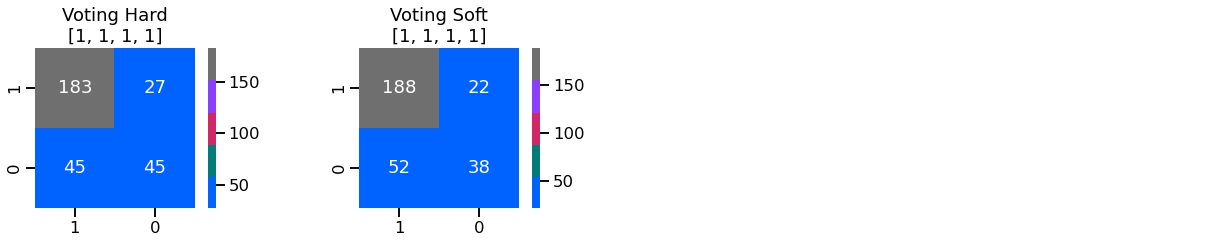

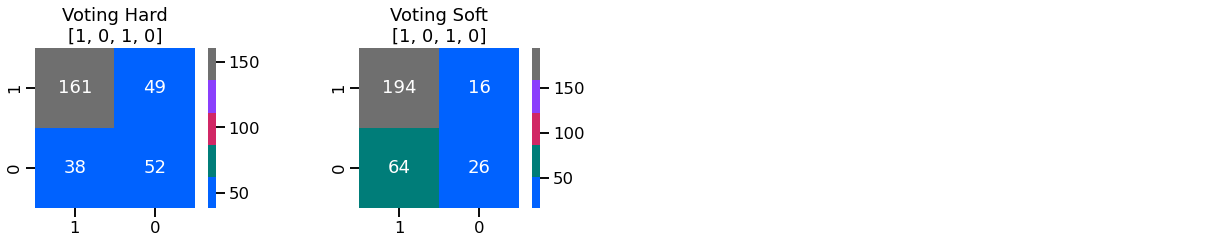

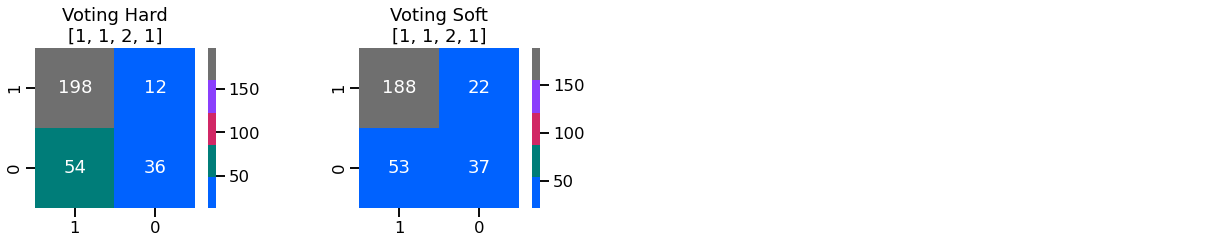

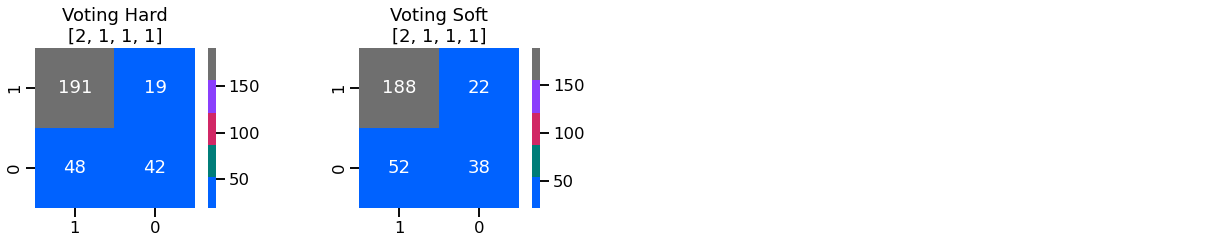

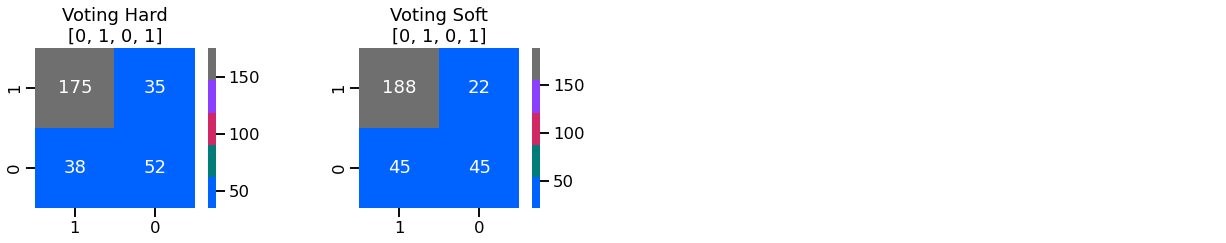

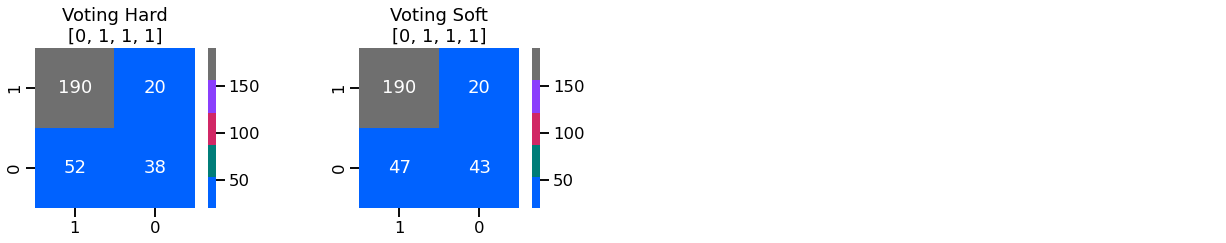

In [35]:
for w in weights:
    voting_tests(w, voting_estimators)

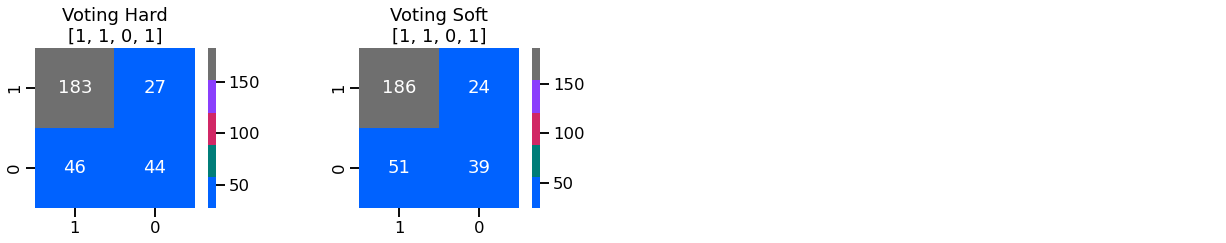

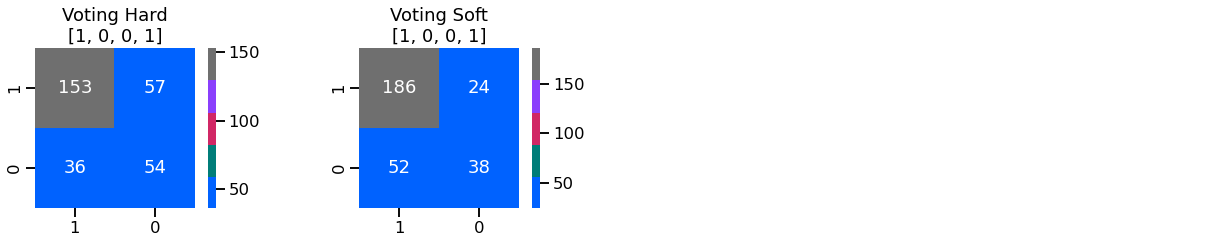

In [36]:
weights_2 = [[1,1,0,1],[1,0,0,1]]
for w in weights_2:
    voting_tests(w, voting_estimators)

In [37]:
base_estimators = [('LR', lr_model),
                   ('KNN', knn_GS_model.best_estimator_),
                   ('gs_ada_dt', ada_DT_GS_model.best_estimator_)]

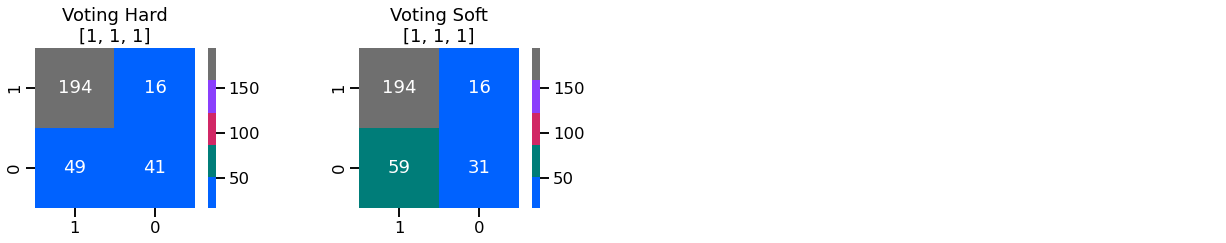

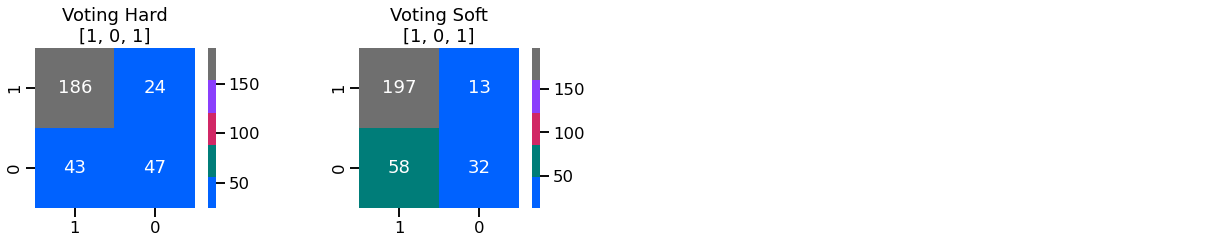

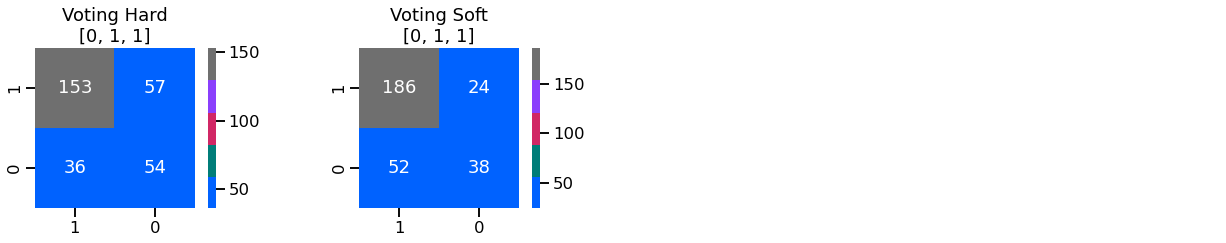

In [38]:
weights_3 = [[1,1,1],[1,0,1],[0,1,1]]
for w in weights_3:
    voting_tests(w, base_estimators)

### Voting between svc_GS and ada_model_SVC

In [39]:
voting_models = [('GS SVC' , svc_GS_model.best_estimator_),
                ('Ada SVC', ada_model_SVC)]

H:\Users\Valhala\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
H:\Users\Valhala\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


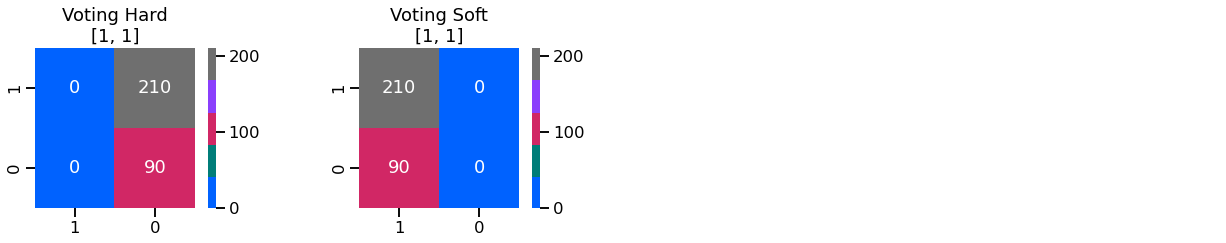

In [40]:
weights_4 = [[1,1]]
for w in weights_4:
    voting_tests(w, voting_models)

### Saving the best model

In [52]:
voting_model_hard = VotingClassifier(estimators = [('ada_dt', ada_model_DT), ('gs_ada_dt', ada_DT_GS_model.best_estimator_)], 
                                voting = 'hard').fit(X_train, y_train)
voting_model_soft = VotingClassifier(estimators = [('ada_dt', ada_model_DT), ('gs_ada_dt', ada_DT_GS_model.best_estimator_)], 
                                voting = 'soft').fit(X_train, y_train)

## Random Forest

In [16]:
rf_model = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=False,
                            n_jobs=-1, 
                            n_estimators = 200).fit(X_train, y_train)
rf_model_predict = rf_model.predict(X_test)

### Finding best amount of trees

H:\Users\Valhala\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
H:\Users\Valhala\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


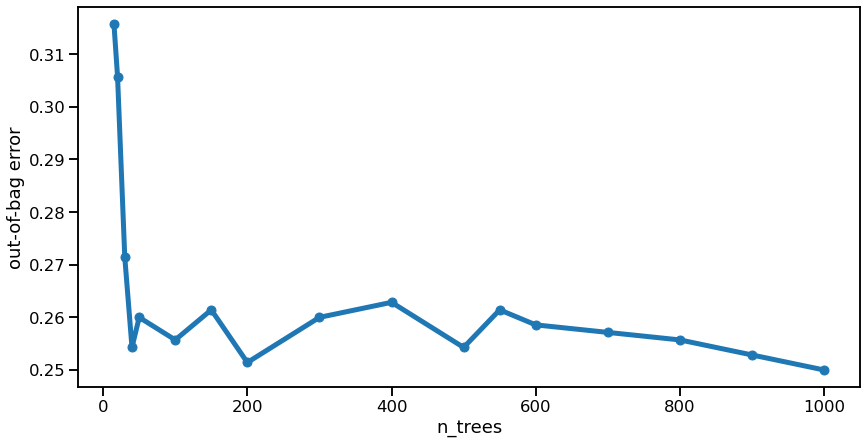

In [103]:
oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400, 500, 550, 600, 700, 800, 900, 1000]:
    
    # Use this to set the number of trees
    rf_model.set_params(n_estimators=n_trees)

    # Fit the model
    rf_model.fit(X_train, y_train)

    # Get the oob error
    oob_error = 1 - rf_model.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

ax = rf_oob_df.plot(legend=False, marker='o', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error');

### Grid search with specificity scoring (SPC)

In [13]:
rf_grid = {'n_estimators' : list(range(200, 550, 50)),
           'criterion' : ['gini', 'entropy'],
           'class_weight' : ['balanced', 'balanced_subsample', None]}
rf_GS_model_specificity = GridSearchCV(rf_model, 
                           param_grid = rf_grid,
                           scoring = specificity,
                           n_jobs = -1)
rf_GS_predict_specificity = rf_GS_model_specificity.fit(X_train, y_train).predict(X_test)
rf_GS_model_specificity.best_params_

{'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'n_estimators': 450}

### Grid search with Negative Predictive Value Scoring (NPV)

In [14]:
rf_GS_model_npv = GridSearchCV(rf_model, 
                           param_grid = rf_grid,
                           scoring = npv,
                           n_jobs = -1)
rf_GS_predict_npv = rf_GS_model_npv.fit(X_train, y_train).predict(X_test)
rf_GS_model_npv.best_params_

{'class_weight': None, 'criterion': 'entropy', 'n_estimators': 400}

### Confusion matrix

,precision,recall,fscore,specificity,NPV,accuracy
Base Random Forest,0.766537,0.938095,0.843683,0.697674,0.333333,0.756667
GS Random Forest\nScoring: Specificity,0.770115,0.957143,0.853503,0.769231,0.333333,0.770000
GS Random Forest\nScoring: NPV,0.775591,0.938095,0.849138,0.717391,0.366667,0.766667


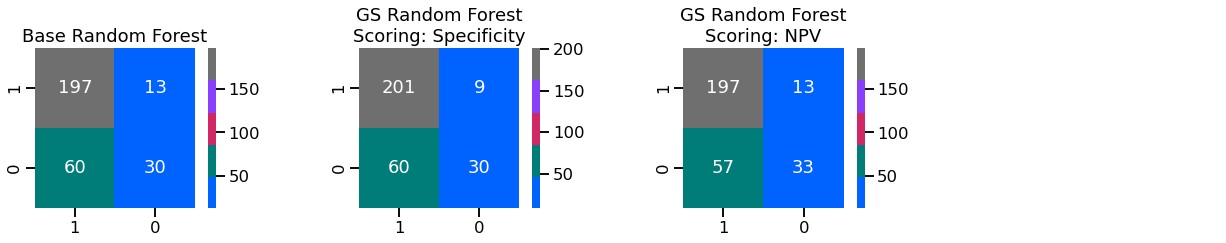

In [18]:
predictions = [rf_model_predict,
               rf_GS_predict_specificity, 
               rf_GS_predict_npv]
labels = ['Base Random Forest',
          'GS Random Forest\nScoring: Specificity', 
          'GS Random Forest\nScoring: NPV']
plot_models(predictions, labels)

### Grid Search CV on Random Forest Bagging

In [19]:
bagging_grid = {'n_estimators' : [10, 20, 50], 
                'max_samples' : [1.0, 10.0, 20.0, 50.0, 100.0, 500.0],
                'max_features' : [1.0, 5.0, 10.0, 20.0], 
                'warm_start' : [True, False],
                'random_state' : [42]}
bagging_GS = BaggingClassifier(rf_GS_model_npv.best_estimator_)
bagging_GS_model = GridSearchCV(bagging_GS, 
                               param_grid = bagging_grid, 
                               scoring = npv, 
                               n_jobs = -1).fit(X_train, y_train)
GS_bagging_RF_predict = bagging_GS_model.predict(X_test)

In [20]:
bagging_GS_model.best_estimator_

BaggingClassifier(base_estimator=RandomForestClassifier(criterion='entropy',
                                                        n_estimators=400,
                                                        n_jobs=-1,
                                                        oob_score=True,
                                                        random_state=42),
                  random_state=42, warm_start=True)

### Comparison of Random Forest Models

,precision,recall,fscore,specificity,NPV,accuracy
GS KNN\nScoring: NPV,0.790244,0.771429,0.780723,0.494737,0.522222,0.696667
GS Random Forest\nScoring: Specificity,0.770115,0.957143,0.853503,0.769231,0.333333,0.770000
GS Random Forest\nScoring: NPV,0.775591,0.938095,0.849138,0.717391,0.366667,0.766667
GS Bagging RF\nScoring: NPV,0.777778,0.966667,0.861996,0.820513,0.355556,0.783333


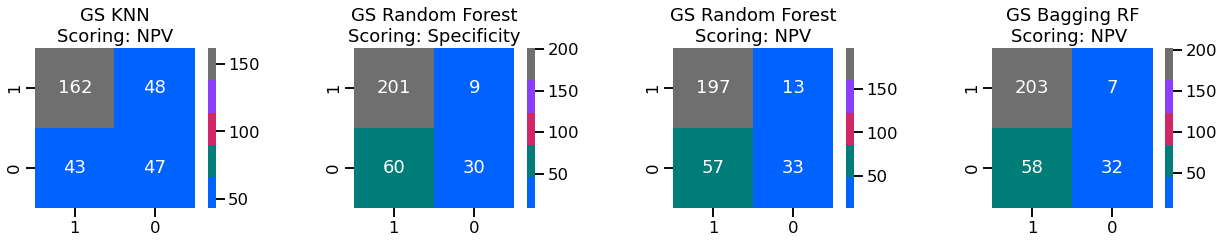

In [118]:
predictions_2 = [knn_GS_predict, 
               rf_GS_predict_specificity, 
               rf_GS_predict_npv,
               GS_bagging_RF_predict]
labels_2 = ['GS KNN\nScoring: NPV', 
          'GS Random Forest\nScoring: Specificity', 
          'GS Random Forest\nScoring: NPV',
          'GS Bagging RF\nScoring: NPV ']
plot_models(predictions_2, labels_2)

In [28]:
import pickle

In [119]:
#Pickle the grid searh random forest models to not retrain them:
pickle.dump(rf_GS_model_specificity.best_estimator_, open('rf_GS_model_specificity.p', 'wb'))
pickle.dump(rf_GS_model_npv.best_estimator_, open('rf_GS_model_npv.p', 'wb'))

In [12]:
rf_spc = pickle.load(open('rf_GS_model_specificity.p', 'rb'))

### Feature Importances

In [13]:
rf_spc.feature_importances_

array([0.14454122, 0.09441733, 0.09794368, 0.05608724, 0.06005631,
       0.06169922, 0.04739931, 0.08498979, 0.02543051, 0.00873993,
       0.00546389, 0.00659063, 0.01616837, 0.00872837, 0.02062404,
       0.01551891, 0.01319256, 0.01885457, 0.00073456, 0.00374071,
       0.0055017 , 0.00110752, 0.01025412, 0.002222  , 0.01327853,
       0.01572302, 0.0091924 , 0.00567388, 0.01698505, 0.01630718,
       0.01721219, 0.00800235, 0.00512217, 0.02083013, 0.01633788,
       0.00709398, 0.01044026, 0.01513017, 0.01266433])

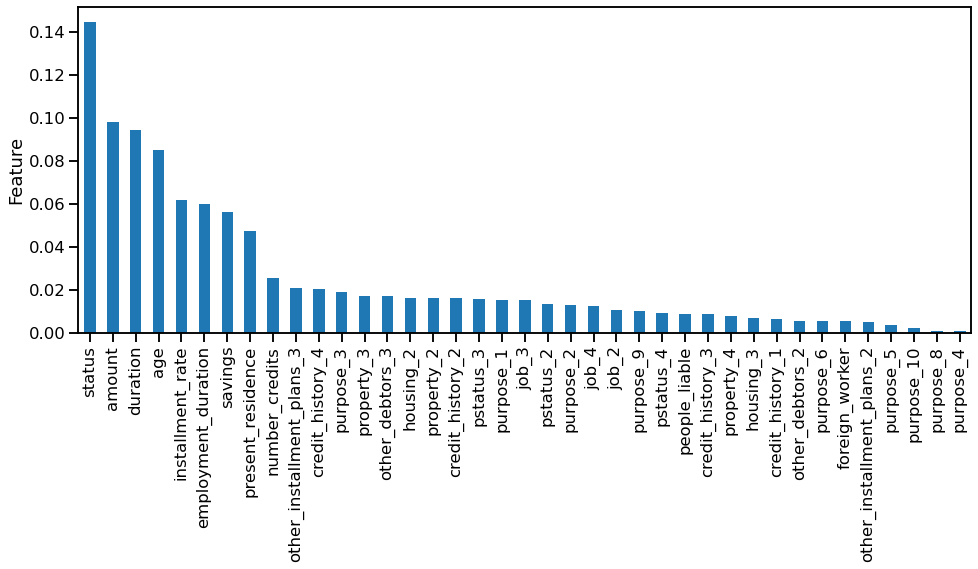

In [14]:
feature_imp = pd.Series(rf_spc.feature_importances_, index=feature_cols).sort_values(ascending=False)

ax = feature_imp.plot(kind='bar', figsize=(16, 6))
ax.set(ylabel='Relative Importance');
ax.set(ylabel='Feature');

## Gradient Boosted Tree

In [22]:
# The parameters to be fit
gb_grid = {'n_estimators': [15, 25, 50, 100, 200, 400],
              'learning_rate': [0.1, 0.01, 0.001, 0.0001],
              'subsample': [1.0, 0.5],
              'max_features': [None, 'auto']}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=gb_grid, 
                      scoring= npv,
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

In [23]:
GV_GBC.best_estimator_

GradientBoostingClassifier(n_estimators=400, random_state=42, subsample=0.5)

In [24]:
GV_GBC_predict = GV_GBC.predict(X_test)

,precision,recall,fscore,specificity,NPV,accuracy
Base Random Forest,0.766537,0.938095,0.843683,0.697674,0.333333,0.756667
GS Random Forest\nScoring: Specificity,0.770115,0.957143,0.853503,0.769231,0.333333,0.770000
GS Random Forest\nScoring: NPV,0.775591,0.938095,0.849138,0.717391,0.366667,0.766667
GS Bagging RF\nScoring: NPV,0.777778,0.966667,0.861996,0.820513,0.355556,0.783333
GS GBC\nScoring: NPV,0.809955,0.852381,0.830626,0.607595,0.533333,0.756667


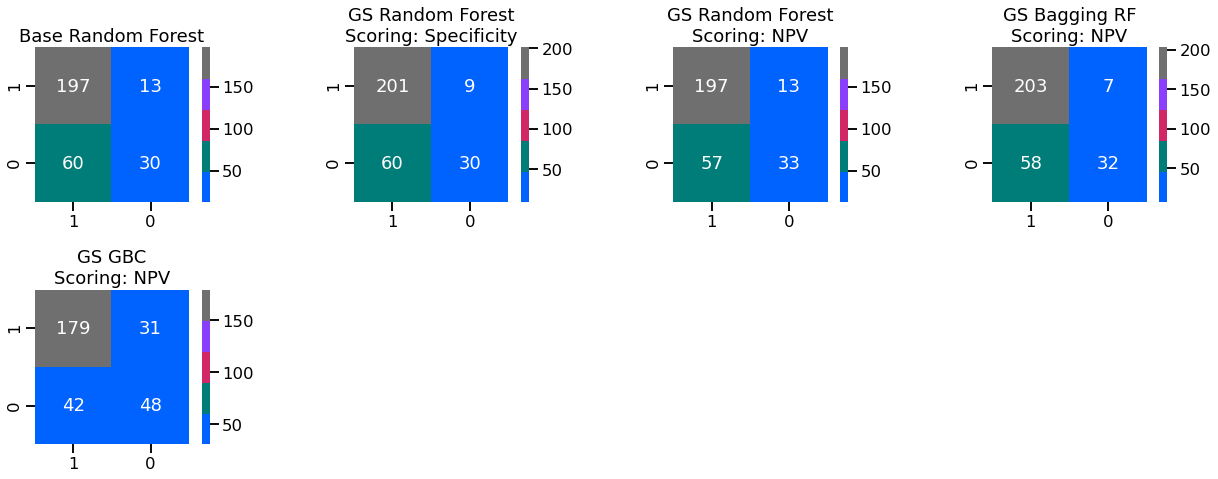

In [26]:
predictions_4 = [rf_model_predict, 
               rf_GS_predict_specificity, 
               rf_GS_predict_npv,
               GS_bagging_RF_predict,
                GV_GBC_predict]
labels_4 = ['Base Random Forest', 
          'GS Random Forest\nScoring: Specificity', 
          'GS Random Forest\nScoring: NPV',
          'GS Bagging RF\nScoring: NPV',
          'GS GBC\nScoring: NPV']
plot_models(predictions_4, labels_4)

# ROC curves for all models

## Create a pickle of all trained models

Since many models were trained, to avoid re-training all of them each time the notebook is started. I will create a pickle out of a dictionary that holds the trained models for further use and easier access.

In [53]:
base_models = {'svc' : svc_model, 
               'svc_gs' : svc_GS_model.best_estimator_, 
               'lr' : lr_model, 
               'knn' : knn_model, 
               'knn_gs' : knn_GS_model.best_estimator_}
pickle.dump(base_models, open('base_models.p', 'wb'))

In [54]:
adaboost_models = {'ada_svc' : ada_model_SVC, 
                   'ada_lr' : ada_model_LR, 
                   'ada_DT' : ada_model_DT, 
                   'ada_svc_gs' : ada_SVC_GS_model.best_estimator_, 
                   'ada_lr_gs' : ada_LR_GS_model.best_estimator_, 
                   'ada_DT_gs' : ada_DT_GS_model.best_estimator_}
pickle.dump(adaboost_models, open('adaboost_models.p', 'wb'))

In [55]:
voting_models = {'voting_hard' : voting_model_hard, 
                 'voting_soft' : voting_model_soft}
pickle.dump(voting_models, open('voting_models.p', 'wb'))

In [56]:
tree_models = {'base_rf' : rf_model, 
               'rf_GS_spc' : rf_GS_model_specificity.best_estimator_, 
               'rf_GS_npv' : rf_GS_model_npv.best_estimator_, 
               'rf_bagging_GS' : bagging_GS_model.best_estimator_, 
               'Gradient Boost' : GV_GBC.best_estimator_}
pickle.dump(tree_models, open('tree_models.p', 'wb'))

In [57]:
training_splits = {'X_train' : X_train, 
                     'y_train' : y_train, 
                     'X_test' : X_test, 
                     'y_test' : y_test}
pickle.dump(training_splits, open('training_splits.p', 'wb'))

In [58]:
trained_models = {'Base Models' : base_models, 
                  'AdaBoost Models' : adaboost_models, 
                  'Voting Models' : voting_models, 
                  'Tree Models' : tree_models}
pickle.dump(trained_models, open('trained_models.p', 'wb'))

## ROC curves

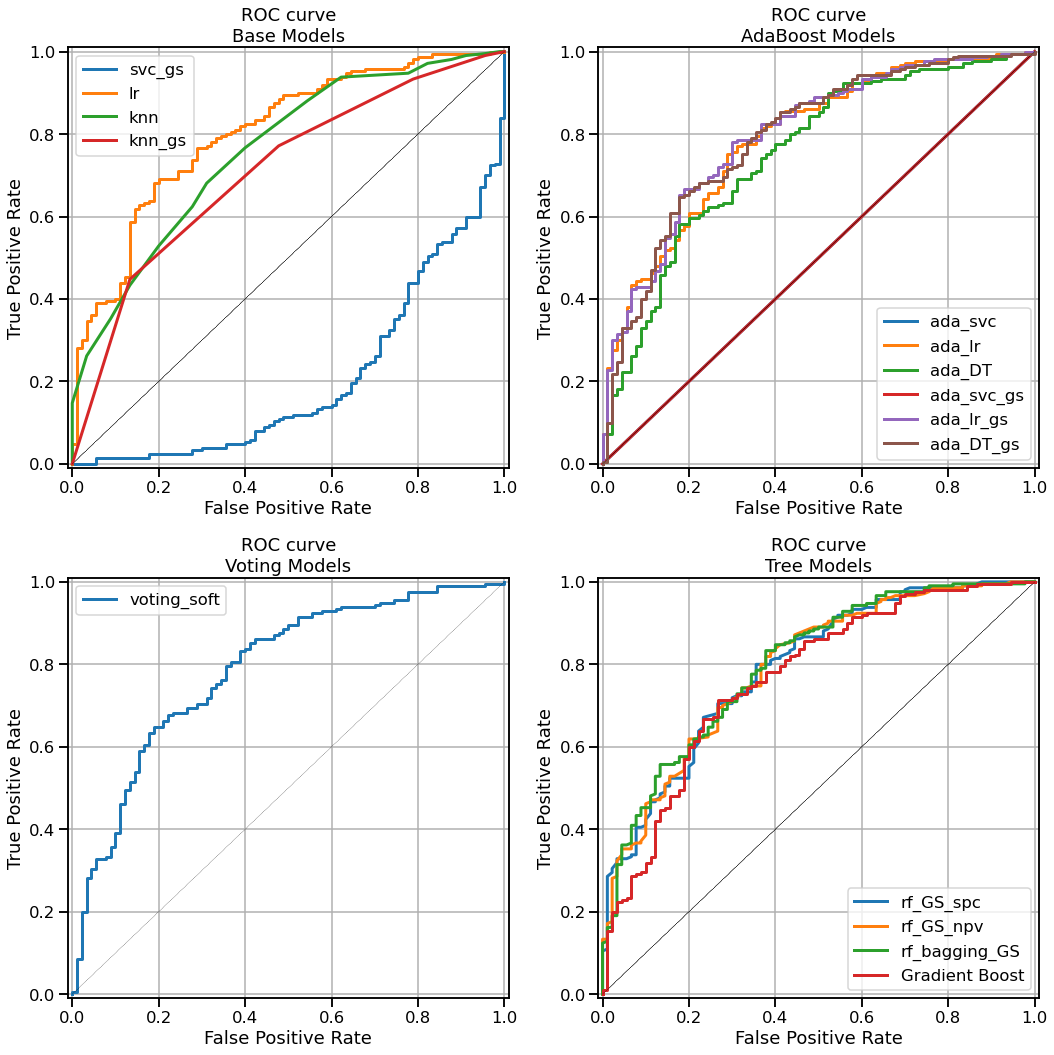

In [153]:
fig, axList = plt.subplots(nrows = 2,ncols=2)
axList = axList.flatten()
fig.set_size_inches(15, 15)
n = 0

for title, each in trained_models.items():
    # Plot the ROC-AUC curve
    ax = axList[n]
    n += 1
    for label, model in each.items():
        # Get the probabilities for each of the two categories
        try:
            y_prob = model.predict_proba(X_test)
        except:
            continue
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        ax.plot(fpr, tpr, linewidth=3, label = label)
        # It is customary to draw a diagonal dotted line in ROC plots.
        # This is to indicate completely random prediction. Deviation from this
        # dotted line towards the upper left corner signifies the power of the model.
        ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
        ax.set(xlabel='False Positive Rate',
               ylabel='True Positive Rate',
               xlim=[-.01, 1.01], ylim=[-.01, 1.01],
               title='ROC curve\n' + title)
        ax.legend()
        ax.grid(True)
plt.tight_layout()

# Upsampling the data

This upsampled data is used on another notebook.

In [46]:
from imblearn.over_sampling import SMOTE

In [96]:
sm = SMOTE(sampling_strategy = 'minority', random_state = 42)
features_rs, credit_risk_rs = sm.fit_resample(features, credit_risk)
df_rs = features_rs.join(credit_risk_rs)
feature_cols_rs = features_rs.columns

In [98]:
#Split the resampled data:
train_idx_rs, test_idx_rs = next(strat_shuf_split.split(features_rs, credit_risk_rs))

# Create the dataframes
X_train_rs = df_rs.loc[train_idx_rs, feature_cols_rs]
y_train_rs = df_rs.loc[train_idx_rs, 'credit_risk']

X_test_rs  = df_rs.loc[test_idx_rs, feature_cols_rs]
y_test_rs  = df_rs.loc[test_idx_rs, 'credit_risk']